In [1]:
import seaborn as sns

print(sns.color_palette("colorblind").as_hex())
print(sns.color_palette('colorblind'))

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']
[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.8705882352941177, 0.5607843137254902, 0.0196078431372549), (0.00784313725490196, 0.6196078431372549, 0.45098039215686275), (0.8352941176470589, 0.3686274509803922, 0.0), (0.8, 0.47058823529411764, 0.7372549019607844), (0.792156862745098, 0.5686274509803921, 0.3803921568627451), (0.984313725490196, 0.6862745098039216, 0.8941176470588236), (0.5803921568627451, 0.5803921568627451, 0.5803921568627451), (0.9254901960784314, 0.8823529411764706, 0.2), (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]


In [2]:
sns.color_palette("colorblind", 11)[2]

(0.00784313725490196, 0.6196078431372549, 0.45098039215686275)

### Investigating created pairs

In [3]:
import os
import pandas as pd
import json
from utils import dpo_dependencies

winning_pairs, losing_originals = dpo_dependencies.load_pair_creation_files('team_pairs_20250209')

c:\Users\HP\anaconda3\envs\thesis_3_9\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
winning_pairs

,original,simp1,simp2,info_equality,creator
1,Die Waldbrände werden durch starke Winde weite...,Starke Winde machen die Wald-Brände groß.,Die Wald-Brände werden durch den Wind weiter v...,y,pc03
2,In geschlossenen Räumen sind bis zu 250 Mensch...,Außerdem dürfen bis zu 250 Menschen in geschlo...,In geschlossenen Räumen darf man bis zu 250 Me...,y,pc03
3,"Ist der Test positiv, wird das den Behörden ge...","Wird das Test-Ergebnis positiv, meldet man es ...","Wenn jemand positiv getestet ist, sagt man es ...",y,pc03
4,"Die Wirtschaft wächst, wenn mehr Dinge hergest...","Eine Wirtschaft wird größer, wenn mehr Sachen ...","Wächst die Wirtschaft, heißt das, dass mehr Di...",y,pc03
5,Dann muss man neue T-Shirts kaufen.,Danach muss man wieder T-Shirts kaufen.,Dann kann man die Shirts nicht mehr tragen. Ma...,n,pc03
...,...,...,...,...,...
1030,"Wien überzeugte vor allem bei Sicherheit, Gesu...",In Wien ist man aber in Sicherheit viel besser...,"Wien ist vor allem bei der Sicherheit, der Ges...",y,pc02
1031,Testen lassen kann man sich auch auf der Donau...,Man kann sich auf der Donauinsel testen lassen.,Das geht auch auf der Donau-Insel. Dort gibt e...,y,pc02
1032,"Wie hoch der finanzielle Schaden ist, kann man...",Der finanzielle Schaden ist bisher noch nicht ...,"Wie hoch der finanzielle Schaden ist, weiß man...",y,pc02
1033,"Adi Hütter kennt Salzburg sehr gut, denn er wa...",Der Trainer Adi Hütter kennt Salzburg sehr gut...,Hütter kennt Salzburg sehr gut. Denn er war do...,y,pc02


In [5]:
from utils import base_dependencies
unique_simplification_pairs = pd.DataFrame(base_dependencies.load_jsonl('outputs/dpo/possible_pairs.jsonl'))
losing_pairs = pd.merge(losing_originals, unique_simplification_pairs, on='original', how='left').reset_index(drop=True)

In [6]:
winning_simplifications = pd.concat([winning_pairs[['original','simp1']].rename(columns={'simp1':'simplification'}), winning_pairs[['original','simp2']].rename(columns={'simp2':'simplification'})]).reset_index(drop=True)
losing_simplifications = pd.concat([losing_pairs[['original','simp1']].rename(columns={'simp1':'simplification'}), losing_pairs[['original','simp2']].rename(columns={'simp2':'simplification'})]).reset_index(drop=True)

In [7]:
dpo_possibilities_orig = pd.DataFrame(base_dependencies.load_jsonl('outputs/dpo/tmp.jsonl'))
dpo_possibilities_orig['inference_parameters'] = 'p' + dpo_possibilities_orig["filename"].str.split("_p").str[1].str.split("_").str[0]
orig_simp_meta = dpo_possibilities_orig[['inference_parameters', 'model', 'orig_id', 'original', 'simplification', 'original_simplification_cossim', 'original_complexity', 'simplification_complexity']]

In [8]:
winning_simplifications = pd.merge(winning_simplifications, orig_simp_meta, on=['original', 'simplification'], how='left')
losing_simplifications = pd.merge(losing_simplifications, orig_simp_meta, on=['original', 'simplification'], how='left')
winning_simplifications['win_or_lose'] = 'winning simps.'
losing_simplifications['win_or_lose'] = 'simps. from losing origs.'
simplifications = pd.concat([winning_simplifications, losing_simplifications]).reset_index(drop=True)

Text(0.5, 1.0, 'Dist of Inference Parameters - Winning Simplifications')

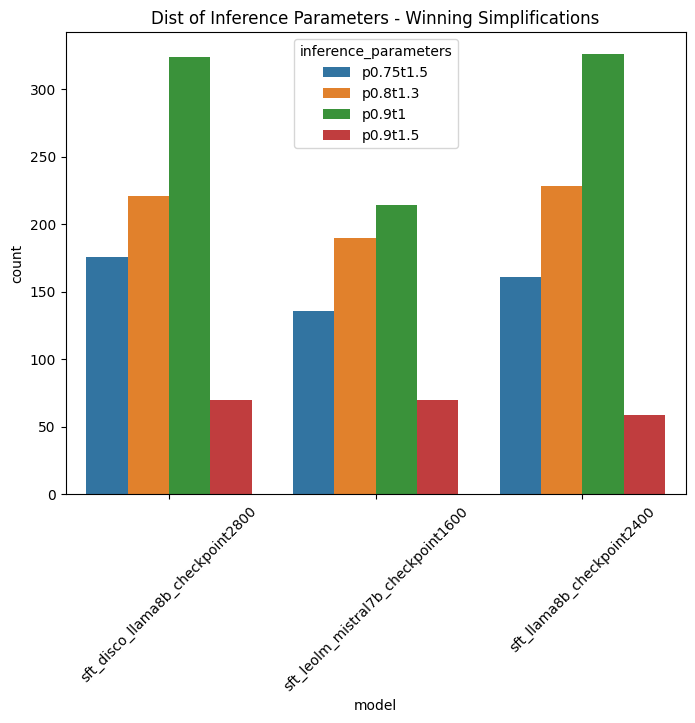

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

winning_inf_freqs = winning_simplifications.groupby(['model', 'inference_parameters']).size().reset_index(name='count')

plt.figure(figsize=(8,6))
sns.barplot(data = winning_inf_freqs, x='model', y='count', hue='inference_parameters')
plt.xticks(rotation=45)
plt.title('Dist of Inference Parameters - Winning Simplifications')

Text(0.5, 1.0, 'Dist of Word Count')

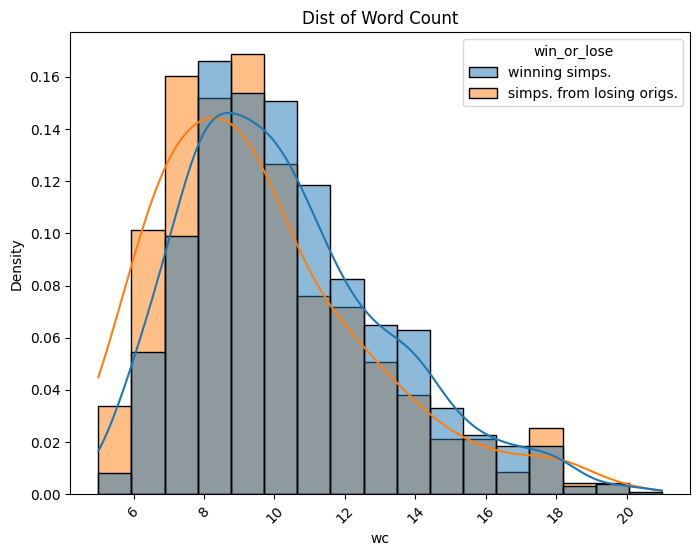

In [10]:
simplifications['wc'] = base_dependencies.wcs(simplifications['original'])
tmp = simplifications.drop_duplicates(subset=['original', 'win_or_lose'])
plt.figure(figsize=(8,6))
sns.histplot(data = tmp, x = 'wc', bins=17, hue='win_or_lose', kde=True, alpha = 0.5, stat="density", common_norm=False)
plt.xticks(rotation=45)
plt.title('Dist of Word Count')

Text(0.5, 1.0, 'Dist of Cosine Similarity')

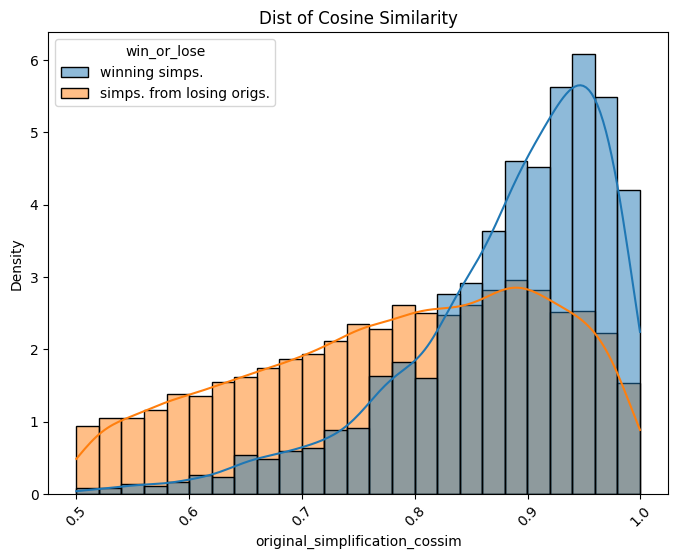

In [11]:
plt.figure(figsize=(8,6))
tmp = simplifications.drop_duplicates(subset=['original', 'simplification', 'win_or_lose'])
sns.histplot(data = tmp[tmp['inference_parameters'] != 'p0.9t1.5'], x = 'original_simplification_cossim', bins=25, hue='win_or_lose', kde=True, alpha = 0.5, stat="density", common_norm=False)
plt.xticks(rotation=45)
plt.title('Dist of Cosine Similarity')

C:\Users\HP\AppData\Local\Temp\ipykernel_23876\820400925.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
C:\Users\HP\AppData\Local\Temp\ipykernel_23876\820400925.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
C:\Users\HP\AppData\Local\Temp\ipykernel_23876\820400925.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)


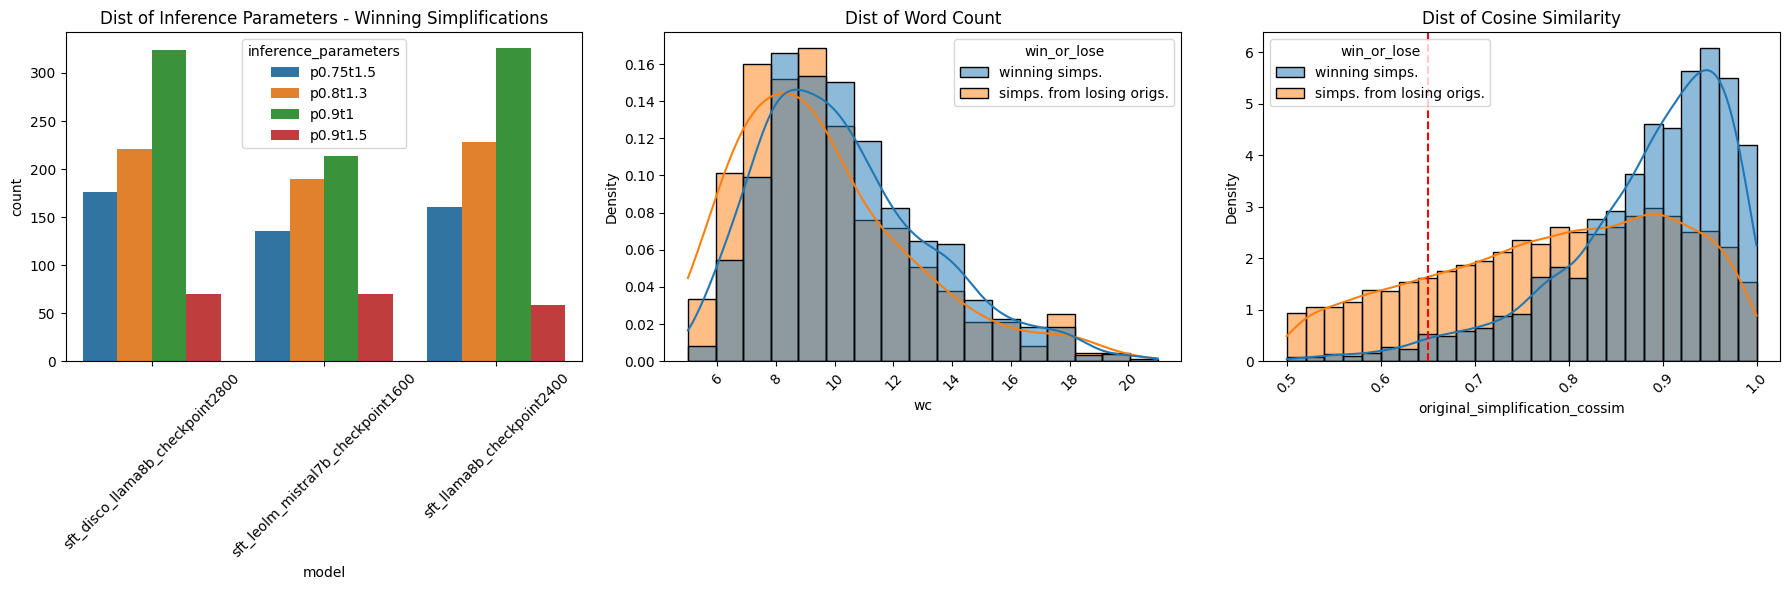

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

winning_inf_freqs = winning_simplifications.groupby(['model', 'inference_parameters']).size().reset_index(name='count')
sns.barplot(data=winning_inf_freqs, x='model', y='count', hue='inference_parameters', ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_title('Dist of Inference Parameters - Winning Simplifications')

simplifications['wc'] = base_dependencies.wcs(simplifications['original'])
tmp = simplifications.drop_duplicates(subset=['original', 'win_or_lose'])
sns.histplot(data=tmp, x='wc', bins=17, hue='win_or_lose', kde=True, alpha=0.5, stat="density", common_norm=False, ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_title('Dist of Word Count')

tmp = simplifications.drop_duplicates(subset=['original', 'simplification', 'win_or_lose'])
sns.histplot(data=tmp[tmp['inference_parameters'] != 'p0.9t1.5'], x='original_simplification_cossim', bins=25, hue='win_or_lose', kde=True, alpha=0.5, stat="density", common_norm=False, ax=axes[2])
axes[2].axvline(x=0.65, linestyle='dashed', color='red')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)
axes[2].set_title('Dist of Cosine Similarity')

plt.tight_layout()
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_23876\2883787269.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
C:\Users\HP\AppData\Local\Temp\ipykernel_23876\2883787269.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
C:\Users\HP\AppData\Local\Temp\ipykernel_23876\2883787269.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=0)
C:\Users\HP\AppData\Local\Temp\ipykernel_23876\2883787269.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['p = 0

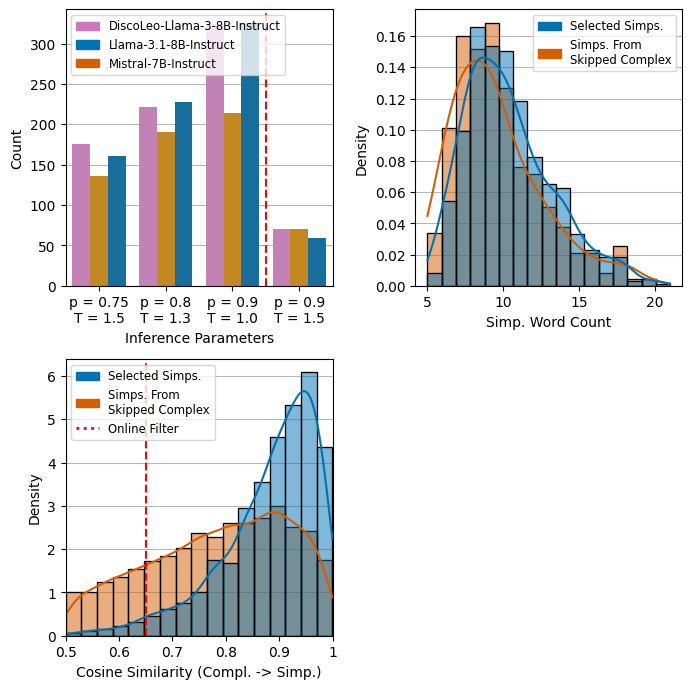

In [19]:
import seaborn as sns; import matplotlib.pyplot as plt; from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, axes = plt.subplots(2, 2, figsize=(7, 7)); axes = axes.flatten()

cb_palette = {'winning simps.': '#0072B2', 'simps. from losing origs.': '#D55E00'}
model_order = ['sft_llama8b_checkpoint2400', 'sft_disco_llama8b_checkpoint2800', 'sft_leolm_mistral7b_checkpoint1600']
model_palette = {model: base_dependencies.return_model_color(model.lower()) for model in model_order}

winning_inf_freqs = winning_simplifications.groupby(['model', 'inference_parameters']).size().reset_index(name='count')
sns.barplot(data=winning_inf_freqs, x='inference_parameters', y='count', hue='model', ax=axes[0], palette=model_palette)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].set_xlabel('Inference Parameters')
axes[0].set_ylabel('Count')
axes[0].axvline(x=2.5, linestyle='dashed', color='red')

simplifications['wc'] = base_dependencies.wcs(simplifications['original'])
tmp = simplifications.drop_duplicates(subset=['original', 'win_or_lose'])
sns.histplot(data=tmp, x='wc', bins=17, hue='win_or_lose', palette=cb_palette, kde=True, alpha=0.5, stat="density", common_norm=False, ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].set_xlabel('Simp. Word Count')

tmp = simplifications.drop_duplicates(subset=['original', 'simplification', 'win_or_lose'])
sns.histplot(data=tmp[tmp['inference_parameters'] != 'p0.9t1.5'], x='original_simplification_cossim', bins=17, hue='win_or_lose', palette=cb_palette, kde=True, alpha=0.5, stat="density", common_norm=False, ax=axes[2])
axes[2].axvline(x=0.65, linestyle='dashed', color='red')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=0)
axes[2].set_title('')
axes[2].set_xlabel('Cosine Similarity (Compl. -> Simp.)')
axes[2].set_xlim(0.5, 1)
axes[2].set_xticks([0.5, 0.6, 0.7, 0.8, 0.9, 1])
axes[2].set_xticklabels(['0.5', '0.6', '0.7', '0.8', '0.9', '1'], rotation=0)


model_legend = [
    Patch(color=base_dependencies.return_model_color('disco'), label=base_dependencies.return_proper_model_name('disco')),
    Patch(color=base_dependencies.return_model_color('llama'), label=base_dependencies.return_proper_model_name('llama')),
    Patch(color=base_dependencies.return_model_color('mistral'), label=base_dependencies.return_proper_model_name('mistral')),
]

custom_legend1 = [
    Patch(color='#0072B2', label='Selected Simps.'),
    Patch(color='#D55E00', label='Simps. From \nSkipped Complex'),
]

custom_legend2 = [
    Patch(color='#0072B2', label='Selected Simps.'),
    Patch(color='#D55E00', label='Simps. From \nSkipped Complex'),
    Line2D([0], [0], color='red', linestyle=':', linewidth=2, label='Online Filter')
]

axes[0].legend(handles=model_legend, loc='upper left', fontsize='small')
axes[1].legend(handles=custom_legend1, loc='upper right', fontsize='small')
axes[2].legend(handles=custom_legend2, loc='upper left', fontsize='small')

axes[0].grid(axis='y', linestyle='-', linewidth=0.75, alpha=0.9)
axes[0].set_axisbelow(True)

axes[1].grid(axis='y', linestyle='-', linewidth=0.75, alpha=0.9)
axes[1].set_axisbelow(True)

axes[2].grid(axis='y', linestyle='-', linewidth=0.75, alpha=0.9)
axes[2].set_axisbelow(True)

fig.delaxes(axes[3])

axes[0].set_xticklabels(['p = 0.75\nT = 1.5', 'p = 0.8\nT = 1.3', 'p = 0.9\nT = 1.0', 'p = 0.9\nT = 1.5'], rotation=0)

plt.tight_layout(pad=1.0)

plt.savefig('figures/prefpair_creation_filtering_AppOthers.png', dpi=800)

plt.show()


Text(0.5, 1.0, 'Dist of Complexity Difference')

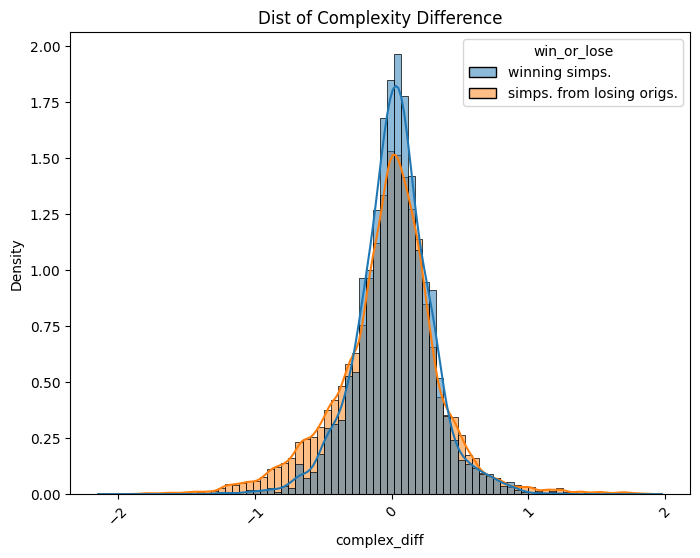

In [13]:
simplifications['complex_diff'] = simplifications['original_complexity'] - simplifications['simplification_complexity']

plt.figure(figsize=(8,6))
sns.histplot(data = simplifications, x = 'complex_diff', bins= 80, hue='win_or_lose', kde=True, alpha = 0.5, stat="density", common_norm=False)
plt.xticks(rotation=45)
plt.title('Dist of Complexity Difference')

In [14]:
simplifications['rouge'] = base_dependencies.pull_rouge(list(simplifications['original']), list(simplifications['simplification']))

In [15]:
for var in ['rouge1', 'rouge2', 'rougeL']:
    simplifications[f'{var}_p'] = simplifications['rouge'].apply(lambda x: x[var][0])
    simplifications[f'{var}_r'] = simplifications['rouge'].apply(lambda x: x[var][1])
    simplifications[f'{var}_f'] = simplifications['rouge'].apply(lambda x: x[var][2])

simplifications = simplifications.drop(columns=['rouge'])

In [33]:
simplifications['win_or_lose'].value_counts()

simps. from losing origs.    155728
winning simps.                 2175
Name: win_or_lose, dtype: int64

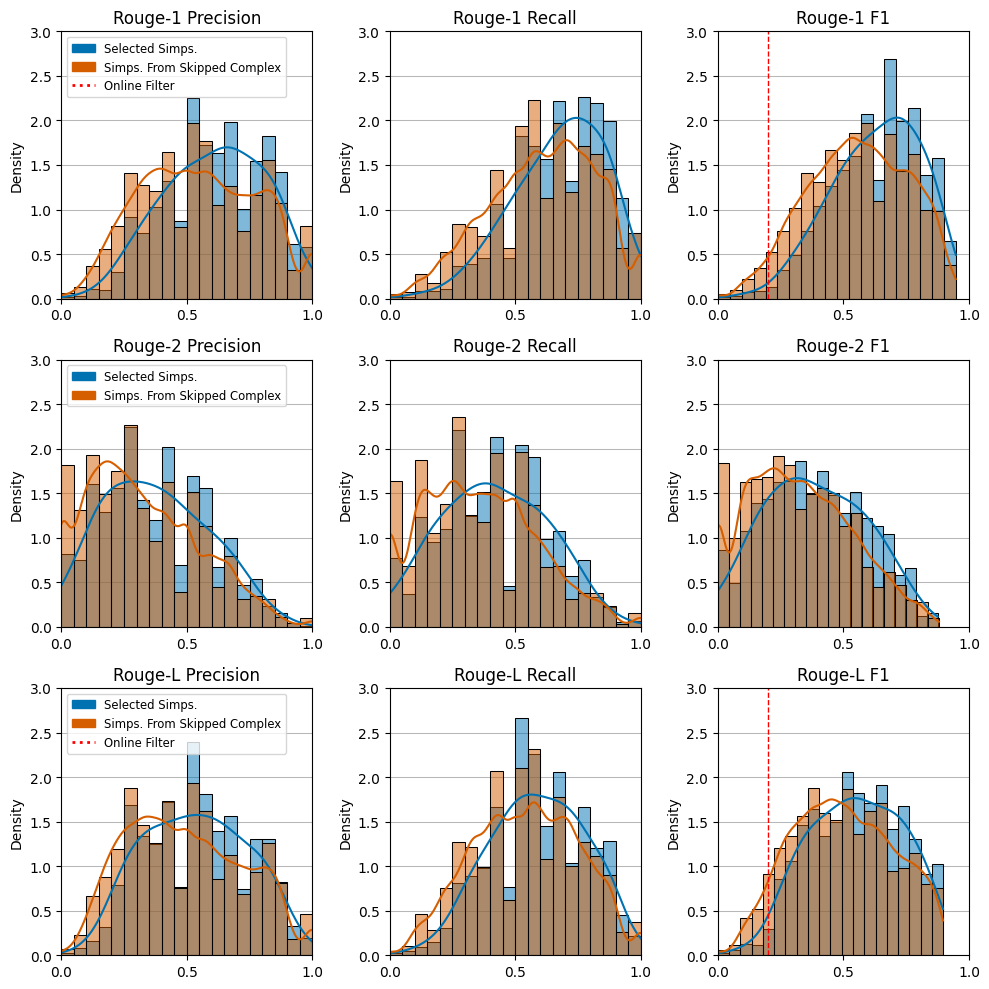

In [41]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()
cb_palette = palette = {
    'winning simps.': '#0072B2',  
    'simps. from losing origs.': '#D55E00' 
}
score_columns = ['rouge1_p', 'rouge1_r', 'rouge1_f',
                 'rouge2_p', 'rouge2_r', 'rouge2_f',
                 'rougeL_p', 'rougeL_r', 'rougeL_f']
titles = ['Rouge-1 Precision', 'Rouge-1 Recall', 'Rouge-1 F1',
          'Rouge-2 Precision', 'Rouge-2 Recall', 'Rouge-2 F1',
          'Rouge-L Precision', 'Rouge-L Recall', 'Rouge-L F1']

for i, col in enumerate(score_columns):
    ax = axes[i]
    for label in ['winning simps.', 'simps. from losing origs.']:
        subset = simplifications[(simplifications['win_or_lose'] == label) & (simplifications['inference_parameters'] != 'p0.9t1.5')]
        sns.histplot(data=subset, x=col, bins=20, stat="density", kde=True, kde_kws={'bw_adjust': 1.5}, color=cb_palette[label], ax=ax, element='bars', fill=True, label=label)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 3)
    ax.set_yticks([0, 0.5, 1, 1.5, 2, 2.5, 3])
    ax.set_xticks([0, 0.5, 1])
    ax.set_title(titles[i])
    ax.set_xlabel('')
    ax.grid(axis='y', linestyle='-', linewidth=0.75, alpha=0.9)
    ax.set_axisbelow(True)
    if i in [2, 8]:
        ax.axvline(x=0.2, linestyle='--', color='red', linewidth=1) 

custom_legend1 = [
    Patch(color='#0072B2', label='Selected Simps.'),
    Patch(color='#D55E00', label='Simps. From Skipped Complex'),
]

custom_legend2 = [
    Patch(color='#0072B2', label='Selected Simps.'),
    Patch(color='#D55E00', label='Simps. From Skipped Complex'),
    Line2D([0], [0], color='red', linestyle=':', linewidth=2, label='Online Filter')
]

axes[0].legend(handles=custom_legend2, loc='upper left', fontsize='small')
axes[3].legend(handles=custom_legend1, loc='upper left', fontsize='small')
axes[6].legend(handles=custom_legend2, loc='upper left', fontsize='small')

for j in range(len(score_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

plt.savefig('figures/prefpair_creation_filtering_AppRouge.png', dpi=800)
plt.show()

In [22]:
len(winning_pairs)

1030

### Filtering possible_pairs to make peoples' lives easier

In [21]:
simp_pair_col_list = ['model', 'orig_id', 'prompt', 'original', 'original_complexity',
       'simp1', 'simp2', 'wc1', 'wc2', 'perp1', 'perp2', 'cossim1', 'cossim2',
       'simp_comp1', 'simp_comp2', 'o2s1_rouge1_f', 'o2s2_rouge1_f',
       'o2s1_rouge2_f', 'o2s2_rouge2_f', 'o2s1_rougeL_f', 'o2s2_rougeL_f',
       'eops', 'wc_diff', 'perplexity_diff', 'complexity_diff', 's2s_rouge1_f',
       's2s_rouge2_f', 's2s_rougeL_f', 'manual_feedback', 'simp_pair_id',
       'sampling_weight']
# Filters:
fltd_usp = unique_simplification_pairs.copy()
# rouge-L and -1 F1 < 0.2
fltd_usp = fltd_usp[fltd_usp['o2s1_rouge1_f'] >= 0.2]
fltd_usp = fltd_usp[fltd_usp['o2s2_rouge1_f'] >= 0.2]
fltd_usp = fltd_usp[fltd_usp['o2s1_rougeL_f'] >= 0.2]
fltd_usp = fltd_usp[fltd_usp['o2s2_rougeL_f'] >= 0.2]
# cossim < 0.65
fltd_usp = fltd_usp[fltd_usp['cossim1'] >= 0.65]
fltd_usp = fltd_usp[fltd_usp['cossim2'] >= 0.65]
# inference parameters != p0.9t1.5
bad_inference = dpo_possibilities_orig[dpo_possibilities_orig['inference_parameters'] == 'p0.9t1.5']
bad_inference = bad_inference[['original', 'simplification', 'inference_parameters']]
fltd_usp = pd.merge(fltd_usp, bad_inference, how='left', left_on=['original', 'simp1'], right_on=['original', 'simplification'])
fltd_usp = fltd_usp[fltd_usp['inference_parameters'].isna()]
fltd_usp = fltd_usp[simp_pair_col_list]
fltd_usp = pd.merge(fltd_usp, bad_inference, how='left', left_on=['original', 'simp2'], right_on=['original', 'simplification'])
fltd_usp = fltd_usp[fltd_usp['inference_parameters'].isna()]
fltd_usp = fltd_usp[simp_pair_col_list]
fltd_usp = fltd_usp.reset_index()

In [35]:
tmp = pd.merge(winning_pairs, fltd_usp, how='inner', on=['original', 'simp1', 'simp2'])
len(tmp)

784

In [28]:
tmp

,original,simp1,simp2,info_equality,creator,index,model,orig_id,prompt,original_complexity,...,eops,wc_diff,perplexity_diff,complexity_diff,s2s_rouge1_f,s2s_rouge2_f,s2s_rougeL_f,manual_feedback,simp_pair_id,sampling_weight
0,Die Waldbrände werden durch starke Winde weite...,Starke Winde machen die Wald-Brände groß.,Die Wald-Brände werden durch den Wind weiter v...,y,pc03,651043.0,Llama8B,uid_apa_2930,"Vereinfache den folgenden Satz, sodass Mensche...",1.810706,...,10.0,-2.0,3.477011,-0.164337,0.444444,0.375000,0.444444,None,pid_apa1390591,0.571849
1,In geschlossenen Räumen sind bis zu 250 Mensch...,Außerdem dürfen bis zu 250 Menschen in geschlo...,In geschlossenen Räumen darf man bis zu 250 Me...,y,pc03,70026.0,Disco Llama8B,uid_apa_2931,Schreibe den folgenden komplexen Satz in Leich...,1.835091,...,19.0,-5.0,-1.321068,-0.035873,0.409091,0.333333,0.272727,None,pid_apa130103,0.906706
2,"Ist der Test positiv, wird das den Behörden ge...","Wird das Test-Ergebnis positiv, meldet man es ...","Wenn jemand positiv getestet ist, sagt man es ...",y,pc03,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Die Wirtschaft wächst, wenn mehr Dinge hergest...","Eine Wirtschaft wird größer, wenn mehr Sachen ...","Wächst die Wirtschaft, heißt das, dass mehr Di...",y,pc03,70138.0,Disco Llama8B,uid_apa_2935,Schreibe den folgenden komplexen Satz in Leich...,1.435634,...,17.0,-5.0,1.365162,-0.408826,0.266667,0.000000,0.200000,None,pid_apa130312,0.900481
4,Dann muss man neue T-Shirts kaufen.,Danach muss man wieder T-Shirts kaufen.,Dann kann man die Shirts nicht mehr tragen. Ma...,n,pc03,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,"Wien überzeugte vor allem bei Sicherheit, Gesu...",In Wien ist man aber in Sicherheit viel besser...,"Wien ist vor allem bei der Sicherheit, der Ges...",y,pc02,35417.0,Disco Llama8B,uid_apa_194,Schreibe den folgenden komplexen Satz in Leich...,1.943361,...,18.0,6.0,1.105517,-0.012153,0.325581,0.097561,0.279070,None,pid_apa65543,0.933548
1037,Testen lassen kann man sich auch auf der Donau...,Man kann sich auf der Donauinsel testen lassen.,Das geht auch auf der Donau-Insel. Dort gibt e...,y,pc02,613944.0,Llama8B,uid_apa_1946,Schreibe den folgenden komplexen Satz um und v...,1.442455,...,12.0,-4.0,0.019878,-0.229891,0.181818,0.100000,0.181818,None,pid_apa1327700,0.999984
1038,"Wie hoch der finanzielle Schaden ist, kann man...",Der finanzielle Schaden ist bisher noch nicht ...,"Wie hoch der finanzielle Schaden ist, weiß man...",y,pc02,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1039,"Adi Hütter kennt Salzburg sehr gut, denn er wa...",Der Trainer Adi Hütter kennt Salzburg sehr gut...,Hütter kennt Salzburg sehr gut. Denn er war do...,y,pc02,35687.0,Disco Llama8B,uid_apa_1949,Schreibe den folgenden komplexen Satz in Leich...,1.520815,...,10.0,5.0,-0.830359,0.106278,0.580645,0.413793,0.580645,None,pid_apa66118,0.962072


In [22]:
fltd_usp

,index,model,orig_id,prompt,original,original_complexity,simp1,simp2,wc1,wc2,...,eops,wc_diff,perplexity_diff,complexity_diff,s2s_rouge1_f,s2s_rouge2_f,s2s_rougeL_f,manual_feedback,simp_pair_id,sampling_weight
0,0,Disco Llama8B,uid_apa_10,"Vereinfache den folgenden Satz, sodass Mensche...",Die Grenzen in Slowenien werden für EU-Bürger ...,1.326076,Die Grenze von Slowenien öffnet wieder für Rei...,Von nun an können EU-Bürger wieder nach Slowen...,22,14,...,22,8,-1.054177,-0.138695,0.347826,0.045455,0.260870,None,pid_apa0,0.939560
1,1,Disco Llama8B,uid_apa_10,"Vereinfache den folgenden Satz, sodass Mensche...",Die Grenzen in Slowenien werden für EU-Bürger ...,1.326076,Dafür werden in Slowenien die Grenzen für EU-B...,Von nun an können EU-Bürger wieder nach Slowen...,9,14,...,11,-5,1.209923,-0.388409,0.562500,0.266667,0.312500,None,pid_apa2,0.920946
2,2,Disco Llama8B,uid_apa_10,"Vereinfache den folgenden Satz, sodass Mensche...",Die Grenzen in Slowenien werden für EU-Bürger ...,1.326076,Slowenien macht die Grenze zu Österreich für a...,Von nun an können EU-Bürger wieder nach Slowen...,10,14,...,18,-4,1.327605,-0.349248,0.322581,0.137931,0.193548,None,pid_apa4,0.905615
3,4,Disco Llama8B,uid_apa_10,"Vereinfache den folgenden Satz, sodass Mensche...",Die Grenzen in Slowenien werden für EU-Bürger ...,1.326076,Von nun an können EU-Bürger wieder nach Slowen...,Die Grenzen zwischen Slowenien und den anderen...,14,15,...,17,-1,1.447450,0.073712,0.461538,0.216216,0.256410,None,pid_apa7,0.888841
4,5,Disco Llama8B,uid_apa_10,"Vereinfache den folgenden Satz, sodass Mensche...",Die Grenzen in Slowenien werden für EU-Bürger ...,1.326076,Die Grenze in Slowenien wird für EU-Bürger geö...,Von nun an können EU-Bürger wieder nach Slowen...,8,14,...,14,-6,-1.387794,-0.608348,0.466667,0.214286,0.333333,None,pid_apa8,0.897550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750158,908361,Llama8B,uid_lhapa_9997,Schreibe den folgenden komplexen Satz in Leich...,Ob Weibchen oder Männchen konnten die Tierpfle...,2.108661,Dafür wissen die Tier-Pfleger noch nicht. Ob e...,"Ob es Weibchen oder Männchen sind, weiß man no...",19,17,...,12,2,0.047399,-0.426090,0.585366,0.256410,0.292683,None,pid_lhapa1863125,0.999901
750159,908364,Llama8B,uid_lhapa_9997,Schreibe den folgenden komplexen Satz in Leich...,Ob Weibchen oder Männchen konnten die Tierpfle...,2.108661,Dafür wissen die Tier-Pfleger noch nicht. Ob e...,"Die Tier-Pfleger haben noch nicht gewusst, ob ...",19,14,...,8,5,0.266262,0.150609,0.684211,0.500000,0.526316,None,pid_lhapa1863132,0.996753
750160,908365,Llama8B,uid_lhapa_9997,Schreibe den folgenden komplexen Satz in Leich...,Ob Weibchen oder Männchen konnten die Tierpfle...,2.108661,"Ob es Weibchen oder Männchen war, das konnten ...","Ob es Weibchen oder Männchen sind, weiß man no...",12,17,...,11,-5,0.548517,-0.469663,0.625000,0.466667,0.625000,None,pid_lhapa1863144,0.986233
750161,908367,Llama8B,uid_lhapa_9997,Schreibe den folgenden komplexen Satz in Leich...,Ob Weibchen oder Männchen konnten die Tierpfle...,2.108661,"Die Tier-Pfleger haben noch nicht gewusst, ob ...","Ob es Weibchen oder Männchen war, das konnten ...",14,12,...,8,2,-0.767380,-0.107035,0.620690,0.370370,0.482759,None,pid_lhapa1863151,0.973053


In [25]:
for file in os.listdir('outputs/dpo/possible_pairs_20250209/'):
    print('\n')
    print(file)
    tmp_pp = pd.read_json('outputs/dpo/possible_pairs_20250209/' + file, lines=True)
    print(len(tmp_pp['original'].unique()), len(tmp_pp))
    tmp_pp = pd.merge(tmp_pp, fltd_usp, how='inner', on=['orig_id', 'original', 'simp1', 'simp2', 'simp_pair_id', 'model'])
    print(len(tmp_pp['original'].unique()), len(tmp_pp))
    tmp_pp = tmp_pp[["orig_id","original","simp1","simp2","simp_pair_id","model"]]
    tmp_pp.to_json('outputs/dpo/' + file, orient='records', lines=True)
    #save in outputs/dpo/

#print length differential (simplifications and originals)



possible_pairs_1200.jsonl
600 191990
600 84036


possible_pairs_1800.jsonl
600 191142
600 85364


possible_pairs_2400.jsonl
600 191444
600 84619


possible_pairs_3000.jsonl
600 185062
600 75631


possible_pairs_3300.jsonl
300 81514
299 29878


possible_pairs_3600.jsonl
300 83589
300 30750


possible_pairs_4200.jsonl
600 166644
600 62398


possible_pairs_4800.jsonl
600 165478
600 61287


possible_pairs_5400.jsonl
600 163915
600 59512


possible_pairs_600.jsonl
600 195999
600 86424


possible_pairs_6000.jsonl
600 163253
600 59382


possible_pairs_6600.jsonl
313 82684
312 30882


#### Prompt length vs completion length

5.6273331372128

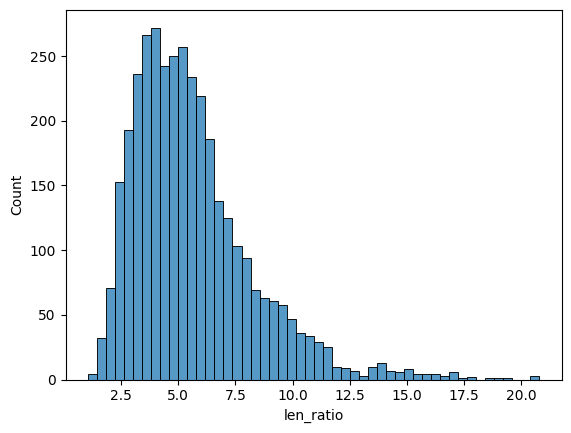

In [14]:
import pandas as pd
from utils import base_dependencies
import seaborn as sns
tmp = pd.read_json('critical_saves/sft_data/sft_train.jsonl', lines=True)
tmp['prompt_wc'] = base_dependencies.wcs(tmp['prompt'])
tmp['completion_wc'] = base_dependencies.wcs(tmp['completion'])
tmp['len_ratio'] = tmp['prompt'].apply(len) / tmp['completion'].apply(len)
tmp['wc_ratio'] = tmp['prompt_wc'] / tmp['completion_wc']
sns.histplot(tmp, x='len_ratio')
tmp['len_ratio'].mean()

### Investigating Prompts

In [20]:
# import dev dataset
dev_data = pd.DataFrame(base_dependencies.load_jsonl('outputs/generations/for_length_investigation/sft_dev.jsonl')[0:400])
dev_data['generation'] = list(pd.read_json('outputs/generations/for_length_investigation/sft_llama8b_checkpoint3200.json')[0])
dev_data['gen_wc'] = base_dependencies.wcs(dev_data['generation'])
dev_data

,original,prompt,completion,generation,gen_wc
0,Man kann von Montag bis Freitag zwischen 9 und...,Schreibe den folgenden komplexen Satz in Leich...,Die Hotline ist von Montag bis Freitag zwische...,Man kann von Montag bis Freitag zwischen 9 und...,12
1,Außerdem darf es in Restaurants wieder Buffets...,Schreibe den folgenden komplexen Satz um und v...,"Dort darf es wieder Buffets geben, wo man sich...",Außerdem darf es wieder Buffets mit Selbstbedi...,24
2,"Er hat in mehreren ""Star Wars""-Teilen ein groß...","Formulieren Sie den komplexen Satz um, indem S...",Er steckte in den Filmen in einem Fellkostüm u...,"Er hat auch in den ""Star Wars""-Filmen mitgespi...",17
3,Die bis dahin älteste Höhlenmalerei wurde eben...,Schreibe den folgenden komplexen Satz in Leich...,Die bisher älteste Höhlenmalerei der Welt wurd...,Die älteste Höhlen-Malerei auf der Welt wurde ...,22
4,Insgesamt sind mehr als 12.600 Menschen an dem...,Schreiben Sie den folgenden komplexen Satz in ...,Mehr als 12.600 Menschen sind von dem Virus kr...,Insgesamt sind mehr als 12.600 Menschen an dem...,22
...,...,...,...,...,...
395,"Ein Psychologe vermutet, dass die ""Oddly Satis...","Vereinfache den folgenden Satz, sodass Mensche...","Ein Psychologe glaubt, dass die Zuschauer nach...","Ein Psychologe glaubt, dass die ""Oddly Satisfy...",27
396,Das hat er bis jetzt erfolgreich geheim gehalten.,Schreibe den folgenden komplexen Satz um und v...,Das hat Banksy bis jetzt geheim gehalten.,Bisher hat er das geheim halten können.,7
397,Die Lombardei ist eine Region im Norden Italie...,"Vereinfache den folgenden Satz, sodass Mensche...",Die Lombardei ist eine Region im Norden von It...,Die Lombardei ist eine Region in Italien. Sie ...,20
398,"Um wie viel genau die Wirtschaft wachsen wird,...",Schreibe den folgenden komplexen Satz in Leich...,"Um wie viel genau, wissen die Wirtschafts-Fors...","Es ist aber nicht klar, wie viel die Wirtschaf...",21


In [33]:
# Define your prompts (cases)
prompts = [
    'Schreibe den folgenden Satz',  # case 1
    'Vereinfache den folgenden Satz',    # case 2
    'um und verwende einfachere Wörter',      # case 3
    'Formulieren Sie den komplexen Satz um',       # case 4
    'Die Vereinfachung soll kurz',       # case 5
    'Die Wörter in deiner Vereinfachung',  # case 6
    'Deine Vereinfachung soll für Menschen',      # case 7
    'Sie können 1) den Satz in mehrere Sätze aufteilen, 2)',    # case 8
    'Hier ist ein Beispiel',          # case 9
    'Hier sind zwei Beispiele'
]

def check_cases(row):
    for idx, prompt in enumerate(prompts, 1):
        if prompt in row:
            return idx
    return None 

dev_data['prompt_num'] = dev_data['prompt'].apply(check_cases)

dev_data

,original,prompt,completion,generation,gen_wc,prompt_num
0,Man kann von Montag bis Freitag zwischen 9 und...,Schreibe den folgenden komplexen Satz in Leich...,Die Hotline ist von Montag bis Freitag zwische...,Man kann von Montag bis Freitag zwischen 9 und...,12,6
1,Außerdem darf es in Restaurants wieder Buffets...,Schreibe den folgenden komplexen Satz um und v...,"Dort darf es wieder Buffets geben, wo man sich...",Außerdem darf es wieder Buffets mit Selbstbedi...,24,3
2,"Er hat in mehreren ""Star Wars""-Teilen ein groß...","Formulieren Sie den komplexen Satz um, indem S...",Er steckte in den Filmen in einem Fellkostüm u...,"Er hat auch in den ""Star Wars""-Filmen mitgespi...",17,4
3,Die bis dahin älteste Höhlenmalerei wurde eben...,Schreibe den folgenden komplexen Satz in Leich...,Die bisher älteste Höhlenmalerei der Welt wurd...,Die älteste Höhlen-Malerei auf der Welt wurde ...,22,9
4,Insgesamt sind mehr als 12.600 Menschen an dem...,Schreiben Sie den folgenden komplexen Satz in ...,Mehr als 12.600 Menschen sind von dem Virus kr...,Insgesamt sind mehr als 12.600 Menschen an dem...,22,8
...,...,...,...,...,...,...
395,"Ein Psychologe vermutet, dass die ""Oddly Satis...","Vereinfache den folgenden Satz, sodass Mensche...","Ein Psychologe glaubt, dass die Zuschauer nach...","Ein Psychologe glaubt, dass die ""Oddly Satisfy...",27,2
396,Das hat er bis jetzt erfolgreich geheim gehalten.,Schreibe den folgenden komplexen Satz um und v...,Das hat Banksy bis jetzt geheim gehalten.,Bisher hat er das geheim halten können.,7,3
397,Die Lombardei ist eine Region im Norden Italie...,"Vereinfache den folgenden Satz, sodass Mensche...",Die Lombardei ist eine Region im Norden von It...,Die Lombardei ist eine Region in Italien. Sie ...,20,2
398,"Um wie viel genau die Wirtschaft wachsen wird,...",Schreibe den folgenden komplexen Satz in Leich...,"Um wie viel genau, wissen die Wirtschafts-Fors...","Es ist aber nicht klar, wie viel die Wirtschaf...",21,10


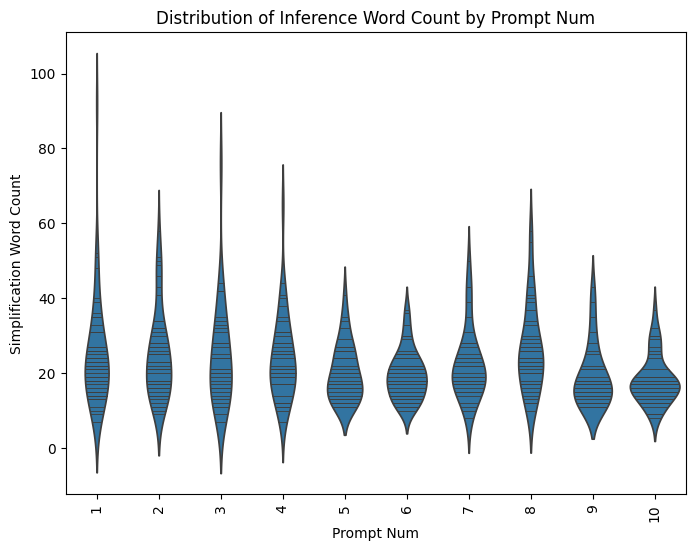

Counter({2: 3, 1: 3, 7: 1, 8: 2, 3: 1, 4: 1})

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Create the violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(data=dev_data, x='prompt_num', y='gen_wc', inner='stick')

plt.title('Distribution of Inference Word Count by Prompt Num')
plt.xticks(rotation=90)
plt.xlabel('Prompt Num')
plt.ylabel('Simplification Word Count')

# Show the plot
plt.show()
Counter(dev_data[dev_data['gen_wc'] >= 50]['prompt_num'])

In [ ]:
f'Schreibe den folgenden Satz in Leichter Sprache um: {original_sentence}. Bitte gib nur eine Vereinfachung an, ohne Einleitung, Alternativen oder Kommentare.',
f'Vereinfache den folgenden Satz, sodass Menschen mit kognitiver Beeinträchtigung den vereinfachten Satz vertstehen können: {original_sentence}. Bitte gib nur die Vereinfachung an, ohne Einleitung, Alternativen oder Kommentare.',
f'Schreibe den folgenden komplexen Satz um und verwende einfachere Wörter, kürzere Sätze und reduzierte grammatikalische Strukturen. Der Inhalt und die Bedeutung sollen nach dem Umschreiben unverändert bleiben. Bitte gib nur die Vereinfachung an, ohne Einleitung, Alternativen oder Kommentare. Komplex: {original_sentence} Leicht:',
f'Formulieren Sie den komplexen Satz um, indem Sie mindestens einen neuen einfachen Satz bilden. Behalten Sie die gleiche Bedeutung des Ausgangssatzes bei. Geben Sie bitte nur die Vereinfachung an, ohne Einleitung, Alternativen oder Kommentare. Komplex: {original_sentence} Leicht:',
f'Schreibe den folgenden komplexen Satz in Leichter Sprache um. Die Vereinfachung soll kurz und von geringer Komplexität sein (durchschnittlich acht bis fünfzehn Wörter pro Satz) und eine geringe Anzahl von Aussagen pro Satz enthalten. Bitte gib nur die Vereinfachung an, ohne Einleitung, Alternativen oder Kommentare. Komplex: {original_sentence} Leicht:',
f'Schreibe den folgenden komplexen Satz in Leichter Sprache um. Die Wörter in deiner Vereinfachung sollen kurz, beschreibend, und häufig verwendet von Menschen mit kognitiver Beeinträchtigung sein. Bitte gib nur die Vereinfachung an, ohne Einleitung, Alternativen oder Kommentare. Komplex: {original_sentence} Leicht:',
f'Schreibe den folgenden komplexen Satz in Leichter Sprache um. Deine Vereinfachung soll für Menschen mit kognitiver Beeinträchtigung in Österreich verständlich sein. Bitte gib nur die Vereinfachung an, ohne Einleitung, Alternativen oder Kommentare. Komplex: {original_sentence} Leicht:',
f'Schreiben Sie den folgenden komplexen Satz in Leichter Sprache um. Sie können 1) den Satz in mehrere Sätze aufteilen, 2) die Wortstellung ändern, um die Grammatik zu vereinfachen, 3) Wörter hinzufügen, um schwierige Konzepte zu erklären, 4) Wörter, die sich mit unnötigen Informationen zusammenhängen, entfernen, und 5) schwierige Wörter durch einfachere Vokabeln ersetzen. Achten Sie darauf, dass der Satz leichter verständlich bleibt, ohne die Bedeutung zu verändern. Bitte geben Sie nur die Vereinfachung an, ohne Einleitung, Alternativen oder Kommentare. Komplex: {original_sentence} Leicht:',
f'Schreibe den folgenden komplexen Satz in Leichter Sprache um. Bitte gib nur die Vereinfachung an, ohne Einleitung, Alternativen oder Kommentare. Hier ist ein Beispiel. Komplex: {original_dev_sentence1} Leicht: {simple_dev_sentence1} Schreibe deine Vereinfachung nach "Leicht:". Komplex: {original_sentence} Leicht:',
f'Schreibe den folgenden komplexen Satz in Leichter Sprache um. Bitte gib nur die Vereinfachung an, ohne Einleitung, Alternativen oder Kommentare. Hier sind zwei Beispiele. Komplex: {original_dev_sentence1} Leicht: {simple_dev_sentence1} Komplex: {original_dev_sentence2} Leicht: {simple_dev_sentence2} Schreibe deine Vereinfachung nach "Leicht:". Komplex: {original_sentence} Leicht:',


In [25]:
# import dev dataset
import pandas as pd
from utils import base_dependencies
dev_data = list(pd.DataFrame(base_dependencies.load_jsonl('data/sft_dev.jsonl')[0:400])['original'])

mistral = list(pd.read_json('outputs/generations/for_simplification_approach_investigation/sft_mistral7b_checkpoint2400.json')[0])
disco_llama = list(pd.read_json('outputs/generations/for_simplification_approach_investigation/sft_disco_llama8b_checkpoint2400.json')[0])
disco_llama_co = list(pd.read_json('outputs/generations/for_simplification_approach_investigation/sft_disco_llama8b_checkpoint800.json')[0])
llama = list(pd.read_json('outputs/generations/for_simplification_approach_investigation/sft_llama8b_checkpoint2400.json')[0])
llama_co = list(pd.read_json('outputs/generations/for_simplification_approach_investigation/sft_llama8b_checkpoint2496.json')[0])
leolm_mistral = list(pd.read_json('outputs/generations/for_simplification_approach_investigation/sft_leolm_mistral7b_checkpoint2400.json')[0])

def five_n_simps(lst, name, n, dev_data):
    print(f'~~~~~~~{name}~~~~~~~')
    for i in range(n):
        simp = lst[i].rstrip("\n")
        print(f'{dev_data[i]} ~~~~~~> {simp}')
    print('\n')

five_n_simps(disco_llama, 'disco_llama', 10, dev_data)
five_n_simps(disco_llama_co, 'disco_llama (completion only)', 10, dev_data)
five_n_simps(llama, 'llama', 10, dev_data)
five_n_simps(llama_co, 'llama (completion only)', 10, dev_data)
five_n_simps(mistral, 'mistral', 10, dev_data)
five_n_simps(leolm_mistral, 'leolm_mistral', 10, dev_data)

~~~~~~~disco_llama~~~~~~~
Unter Präsident Trump gibt es zu viel Wut, zu viel Angst, zu viel Spaltung. ~~~~~~> Präsident Trump ist zu wütend.
Der Gorilla hat nun gute Chancen, wieder gut sehen zu können. ~~~~~~> Der Gorilla kann nun wieder gut sehen.
Harry zeigte sich am Sonntag traurig darüber, dass es soweit gekommen ist. ~~~~~~> Harry zeigte sich traurig darüber.
Alle Besucher sollen Masken tragen und den Sicherheitsabstand einhalten, sagte Anschober. ~~~~~~> Sie sollen eine Maske tragen und den Sicherheits-Abstand einhalten.
Das bedeutet, alle Flüge dorthin und von dort werden gestrichen. ~~~~~~> Das bedeutet, dass alle Flüge dorthin und von dort gestrichen werden.
Bei der Aktion kann jeder mitmachen, der möchte und Freude und Interesse an der Vogelwelt hat. ~~~~~~> Jeder kann mitmachen.
Dabei handelt es sich um einen 60 Jahre alten Whisky der Marke Macallan 1926 aus Schottland. ~~~~~~> Es handelt sich dabei um einen 60 Jahre alten Whisky.
Am Sonntag sind bei einem Unfall mit einem 

In [ ]:
five_n_simps(disco_llama, 'disco_llama', 100, dev_data)
five_n_simps(llama, 'llama', 100, dev_data)

In [21]:
for_inference = pd.DataFrame(base_dependencies.load_jsonl('outputs/dpo/for_inference.jsonl'))

cumulative_store_orig_de_en = pd.DataFrame(base_dependencies.load_jsonl('outputs/dpo/cumulative_stores/orig_de_en.jsonl'))

for_inference = for_inference[~for_inference['original'].isin(cumulative_store_orig_de_en['original'])]

In [23]:
cumulative_store_orig_de_en = pd.DataFrame(base_dependencies.load_jsonl('outputs/dpo/cumulative_stores/original_de_en.jsonl'))
cumulative_store_orig_de_en

,original,original_english
0,Denn das britische Parlament stimmte gegen den...,Because the British Parliament voted against t...
1,Irland hat Österreich am Donnerstag auf eine s...,Ireland put Austria on a so-called red list on...
2,Pro Jahr backen die Menschen in Österreich 26 ...,"Every year, people in Austria bake 26 million ..."
3,Sie lag tot in einem Gebüsch neben einem Parkp...,She was lying dead in a bush next to a parking...
4,In den USA gibt es nur 2 wichtige politische P...,"In the United States, there are only two major..."
...,...,...
7494,September und wollen weitere Staaten zum Mitma...,September and want to get other countries to j...
7495,Ein Entwurf für das Gesetz für Sorgfalt und Ve...,A draft law on care and responsibility in the ...
7496,Die Regelung gilt auch in Taxis und bei Fahrdi...,The regulation also applies to taxis and ride-...
7497,Schlechte Nachrichten für Österreichs Tourismu...,Bad news for Austrian tourism also comes from ...


In [24]:
import pandas as pd
from utils import base_dependencies
import os
import re
from datetime import datetime
files = {}
user = 'ta07'
for filename in os.listdir(f'web_app_test_20250124/{user}/'):
    files[datetime.strptime(filename.split('A_')[1].split('.jsonl')[0], '%Y-%m-%d-%H-%M-%S')] = pd.DataFrame(base_dependencies.load_jsonl(f'web_app_test_20250124/{user}/{filename}'))[['original', 'simplifications', 'preference']]

for timestamp in files.keys():
    tmp = files[timestamp]
    print(len(tmp[~tmp['preference'].isna()]))

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'web_app_test_20250124/ta07/'

In [10]:
tmp = pd.DataFrame(base_dependencies.load_jsonl('outputs/dpo/cumulative_stores/original_simplification_entailment.jsonl'))
print(tmp)
tmp = tmp[['original', 'simplification', 'original_simplification_entailment']]
tmp.to_json('outputs/dpo/cumulative_stores/original_simplification_entailment.jsonl', orient='records', lines=True)

       model orig_id prompt  \
0       None    None   None   
1       None    None   None   
2       None    None   None   
3       None    None   None   
4       None    None   None   
...      ...     ...    ...   
192177  None    None   None   
192178  None    None   None   
192179  None    None   None   
192180  None    None   None   
192181  None    None   None   

                                                 original  \
0       Mai 1869 eröffnet wurde, bestand das Publikum ...   
1       Mai 1869 eröffnet wurde, bestand das Publikum ...   
2       Mai 1869 eröffnet wurde, bestand das Publikum ...   
3       Mai 1869 eröffnet wurde, bestand das Publikum ...   
4       Mai 1869 eröffnet wurde, bestand das Publikum ...   
...                                                   ...   
192177  Hauptbetroffen sind die Transitrouten durch We...   
192178  Hauptbetroffen sind die Transitrouten durch We...   
192179  Hauptbetroffen sind die Transitrouten durch We...   
192180  Hauptbetr